In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')  # plot defaults

In [14]:
import xarray as xr
import salem
import numpy as np
import pandas as pd

In [15]:
import oggm.cfg
from oggm import utils, workflow, tasks, graphics
from oggm.sandbox.edu import run_constant_climate_with_bias

In [16]:
# OGGM options
oggm.cfg.initialize(logging_level='WARNING')
oggm.cfg.PATHS['working_dir'] = utils.gettempdir(dirname='WaterResources')
oggm.cfg.PARAMS['min_ice_thick_for_length'] = 1  # a glacier is defined when ice is thicker than 1m
oggm.cfg.PARAMS['store_model_geometry'] = True
# cfg.PARAMS['continue_on_error'] = True

2025-03-09 15:06:05: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2025-03-09 15:06:05: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2025-03-09 15:06:05: oggm.cfg: Multiprocessing: using all available processors (N=16)
2025-03-09 15:06:05: oggm.cfg: PARAMS['min_ice_thick_for_length'] changed from `0.0` to `1`.
2025-03-09 15:06:05: oggm.cfg: PARAMS['store_model_geometry'] changed from `False` to `True`.


In [17]:
# South Cascade
rgi_id = 'RGI60-02.18778'
# # Hintereisferner
# rgi_id = 'RGI60-11.00897'

In [18]:
tar_path='C:/Users/bookn/Downloads/Senior-Thesis/Data/SouthCascadeData/RGI60-02.18778.tar.gz'
gdir = workflow.init_glacier_directories([rgi_id], from_tar=tar_path)[0]

2025-03-09 15:06:05: oggm.workflow: Execute entity tasks [GlacierDirectory] on 1 glaciers


In [19]:
# # file identifier where the model output is saved
file_id = '_historical_1984_2024'
# # tasks.process_custom_climate_data(gdir, filename='C:/Users/bookn/Downloads/Senior-Thesis/SIA/Data/temp_precip_data.csv')
# # Run the glacier model using the historical climate data provided by your tar file.
tasks.run_with_hydro(gdir,                    # Run on the selected glacier
                     run_task=tasks.run_from_climate_data,  # Use historical climate forcing
                      store_monthly_hydro=True,  # Store monthly hydrological outputs
                     output_filesuffix=file_id)  # Identifier for the output file


In [20]:
with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix=file_id)) as ds:
    # The last step of hydrological output is NaN (we can't compute it for this year)
    ds = ds.isel(time=slice(0, -1)).load()
df=ds.to_dataframe()

In [23]:
df=df[df['calendar_year']>=1984]
df=df[df['calendar_year']<=2024]
df=df.reset_index()
df['date'] = df['time'].astype(int).astype(str) + '-' + df['month_2d'].astype(str).str.zfill(2)
on_glacier_columns = [col for col in df.columns if 'on_glacier_monthly' in col]
df['all_runoff']=df[on_glacier_columns].sum(axis=1)
selected_columns = ['date', 'volume_m3']+on_glacier_columns+['all_runoff']
df_selected = df[selected_columns]
df_selected.to_csv('oggm_runoff.csv', index=False)

print(df_selected)

        date     volume_m3  melt_on_glacier_monthly  \
0    1984-01  2.547884e+08             0.000000e+00   
1    1984-02  2.547884e+08             0.000000e+00   
2    1984-03  2.547884e+08             1.695484e-07   
3    1984-04  2.547884e+08             8.477420e-08   
4    1984-05  2.547884e+08             5.531720e+07   
..       ...           ...                      ...   
427  2019-08  2.191843e+08             3.903341e+09   
428  2019-09  2.191843e+08             1.864702e+09   
429  2019-10  2.191843e+08             0.000000e+00   
430  2019-11  2.191843e+08             0.000000e+00   
431  2019-12  2.191843e+08             3.312917e-07   

     liq_prcp_on_glacier_monthly  snowfall_on_glacier_monthly    all_runoff  
0                   0.000000e+00                 2.268176e+09  2.268176e+09  
1                   0.000000e+00                 1.243305e+09  1.243305e+09  
2                   0.000000e+00                 1.227893e+09  1.227893e+09  
3                   0.00000

In [13]:
from oggm.core import gis
glacier_area_km2 = gdir.rgi_area_km2
print('Glacier area: ', glacier_area_km2, 'km²')
# Compute the total grid domain area
gis.define_glacier_region(gdir, source="SRTM") # Generates the DEM and domain mask
total_domain_area_km2 = gdir.grid.dx**2 * gdir.grid.nx * gdir.grid.ny / 1e6  # Convert m² to km²

print(f"Total Domain Area: {total_domain_area_km2} km²")


Glacier area:  2.924 km²
Total Domain Area: 65.628432 km²


In [14]:
import tarfile

# Path to the outlines tar file
outlines_tar_path = gdir.get_filepath('outlines')

# Open the tar file and list contents
with tarfile.open(outlines_tar_path, "r:gz") as tar:
    files_in_tar = tar.getnames()  # List all files inside the tar archive

# Print the files
print("Files inside outlines.tar.gz:")
for file in files_in_tar:
    print(file)


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\bookn\\AppData\\Local\\Temp\\OGGM\\WaterResources\\per_glacier\\RGI60-02\\RGI60-02.18\\RGI60-02.18778\\outlines.shp'

In [ ]:
import geopandas as gpd

# Load RGI shapefile for Region 02 (Western North America)
rgi_path = utils.get_rgi_region_file("02")
rgi_gdf = gpd.read_file(rgi_path)

# Check if the glacier is in the dataset
if rgi_id in rgi_gdf['RGIId'].values:
    print(f"Glacier {rgi_id} is in the RGI dataset.")
else:
    print(f"Glacier {rgi_id} NOT found in RGI dataset. Check the ID.")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from oggm import cfg, utils, workflow
from oggm.core import gis
import geopandas as gpd
import rasterio
from rasterio.plot import show
tasks.glacier_masks(gdir)
dem_path = gdir.get_filepath('dem')
with rasterio.open(dem_path) as src:
    dem = src.read(1)  # Read the DEM data
    extent = src.bounds  # Get bounding box of the DEM

# Glacier outline
glacier_outline = gpd.read_file(gdir.get_filepath('outlines'))

# Plot the map
fig, ax = plt.subplots(figsize=(8, 6))
show(dem, transform=src.transform, ax=ax, cmap='terrain')  # Plot DEM
glacier_outline.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=2, label='Glacier Outline')  # Glacier outline

# Add labels and title
ax.set_title("South Cascade Glacier - Total Domain Area")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()

plt.show()

In [15]:
# print((ds['melt_on_glacier_monthly']+ds['melt_off_glacier_monthly']+ds['liq_prcp_on_glacier_monthly']+ds['liq_prcp_off_glacier_monthly']+ds['snowfall_on_glacier_monthly']+ds['snowfall_off_glacier_monthly'])/1000)
print((ds['melt_on_glacier_monthly']+ds['liq_prcp_on_glacier_monthly']+ds['snowfall_on_glacier_monthly'])/1000)

<xarray.DataArray (time: 61, month_2d: 12)> Size: 6kB
array([[2225123.48893241,  854494.46608775, 1960869.42257527,
        1214969.83924842,  534072.33959392, 2007317.21655093,
        3454063.93636944, 2932211.92961385, 2837025.74487379,
        1619746.41747216, 2297413.72145706, 1825312.49788377],
       [1032626.32840012, 1411823.74335384, 1138367.90757118,
         910815.71785065, 1136820.30848974, 1862911.23857394,
        3795973.3593414 , 3198626.14760396, 1781029.66139884,
        1468102.16257828, 2526141.113569  ,  868283.56077905],
       [2846580.12615415, 2557949.25920104, 1086533.18214655,
         567426.58765679,  969478.88544889, 2515759.19149801,
        3758426.8750597 , 4149110.07354154, 1896392.59693999,
        1316144.69894882, 1249765.64456545, 2580095.35046016],
       [1517899.05770386,  224323.95375556, 1283329.81486995,
         675576.82433081,  578558.9575327 , 1744301.81006427,
        2930310.16651069, 3142643.60555538, 2365093.89875158,
         7974

In [16]:
import pandas as pd

# 1) Subset the dataset to 1984–2024
ds_subset = ds.sel(time=slice('1984-01-01', '2024-12-31'))

# 2) Extract the time and month dimension info
time_vals = ds_subset['time'].values
print(time_vals)
month_dim_name = ds_subset['melt_on_glacier_monthly'].dims[1]  # e.g. 'month_2d'
num_months = ds_subset[month_dim_name].size  # typically 12

# 3) Build rows of [yyyy-mm, melt_value]
data_rows = []
for i in range(len(time_vals)):
    # Convert each time value to a year
    year = int(time_vals[i])
    # Loop over each month in 0..11
    for m in range(num_months):
        # Format the month string: 'YYYY-MM'
        month_str = f"{year}-{m+1:02d}"

        # Extract the melt value at [time=i, month=m]
        melt_val = ds_subset['melt_on_glacier_monthly'].isel(
            time=i, **{month_dim_name: m}
        ).item()

        data_rows.append([month_str, melt_val])

# 4) Convert to a DataFrame and save to CSV
df = pd.DataFrame(data_rows, columns=['month', 'melt_on_glacier_monthly'])
df['melt_on_glacier_monthly']=df['melt_on_glacier_monthly']/1000
df.loc[df['melt_on_glacier_monthly'] < 1, 'melt_on_glacier_monthly'] = 0

df.to_csv('oggm_runoff_monthly.csv', index=False)

print("Saved monthly melt data for 1984–2024 to melt_on_glacier_monthly_1984_2024.csv")


[1984. 1985. 1986. 1987. 1988. 1989. 1990. 1991. 1992. 1993. 1994. 1995.
 1996. 1997. 1998. 1999. 2000. 2001. 2002. 2003. 2004. 2005. 2006. 2007.
 2008. 2009. 2010. 2011. 2012. 2013. 2014. 2015. 2016. 2017. 2018. 2019.]
Saved monthly melt data for 1984–2024 to melt_on_glacier_monthly_1984_2024.csv


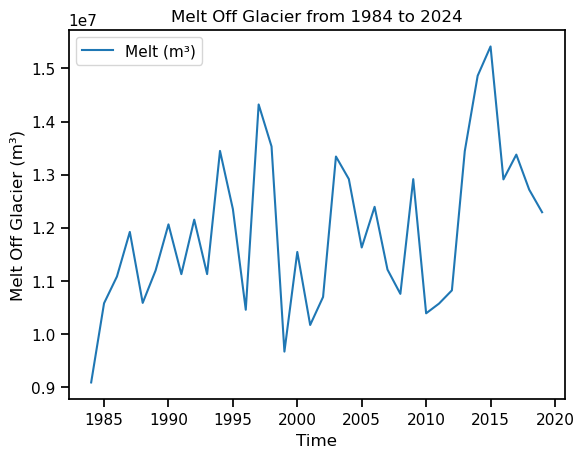

In [17]:
ds_subset = ds.sel(time=slice('1984-01-01', '2024-12-31'))
df = (ds_subset.melt_on_glacier / 1000).to_dataframe(name='melt_on_glacier_m3')

# Save the DataFrame to a CSV file.
df.to_csv('oggm_runoff.csv', index=True)
# Plot melt_off_glacier divided by 1000 (kg to m³ conversion)
(ax := (ds_subset.melt_on_glacier / 1000).plot(label='Melt (m³)', color='C0'))
plt.xlabel('Time')
plt.ylabel('Melt Off Glacier (m³)')
plt.title('Melt Off Glacier from 1984 to 2024')
plt.legend()
plt.show()

Text(0.5, 0, 'Years')

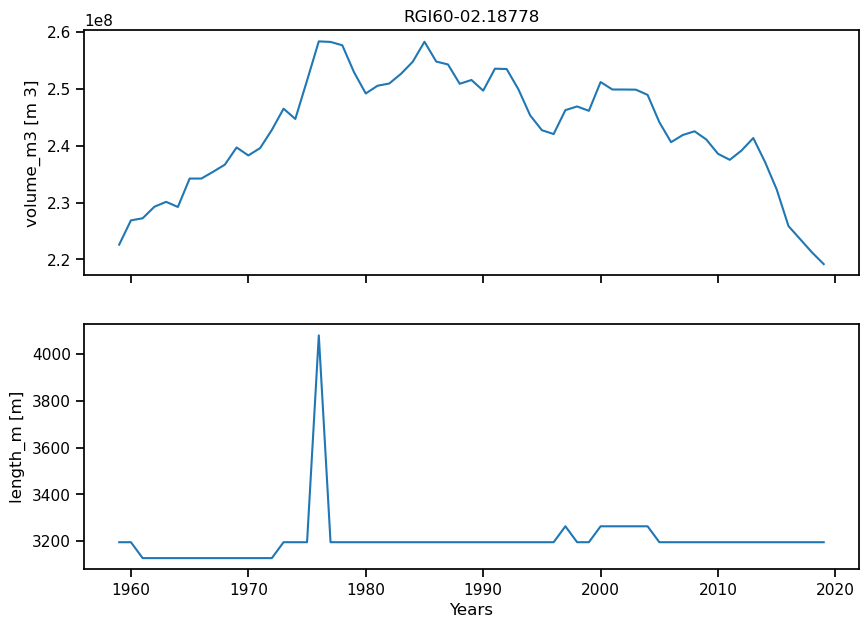

In [18]:
fig, axs = plt.subplots(nrows=2, figsize=(10, 7), sharex=True)
ds.volume_m3.plot(ax=axs[0])
ds.length_m.plot(ax=axs[1])
axs[0].set_xlabel(''); axs[0].set_title(f'{rgi_id}'); axs[1].set_xlabel('Years')

Text(0, 0.5, 'Temperature bias (°C)')

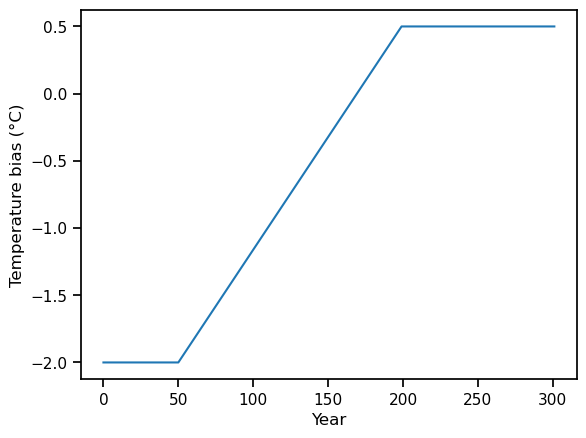

In [19]:
ny_s = 50  # Start
ny_t = 150  # Trend
ny_e = 102  # Stabilisation
temp_bias_ts = np.concatenate([np.full(ny_s, -2.), np.linspace(-2, 0.5, ny_t), np.full(ny_e, 0.5)])
temp_bias_ts = pd.Series(temp_bias_ts, index=np.arange(ny_s + ny_t + ny_e))
temp_bias_ts.plot(); plt.xlabel('Year'); plt.ylabel('Temperature bias (°C)')

In [20]:
# # file identifier where the model output is saved
# file_id = '_lin_temp'

# # We are using the task run_with_hydro to store hydrological outputs along with the usual glaciological outputs
# tasks.run_with_hydro(gdir,
#                      temp_bias_ts=temp_bias_ts,  # the temperature bias timeseries we just created
#                      run_task=run_constant_climate_with_bias,  # which climate scenario? See following notebook for other examples
#                      y0=2009, halfsize=10,  # Period which we will average and constantly repeat
#                      store_monthly_hydro=True,  # Monthly ouptuts provide additional information
#                      init_model_filesuffix='_spinup',  # We want to start from the glacier in equibrium we created earlier
#                      output_filesuffix=file_id);  # an identifier for the output file, to read it later

In [21]:
with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix=file_id)) as ds:
    # The last step of hydrological output is NaN (we can't compute it for this year)
    ds = ds.isel(time=slice(0, -1)).load()

Text(0, 0.5, 'Temperature bias (°C)')

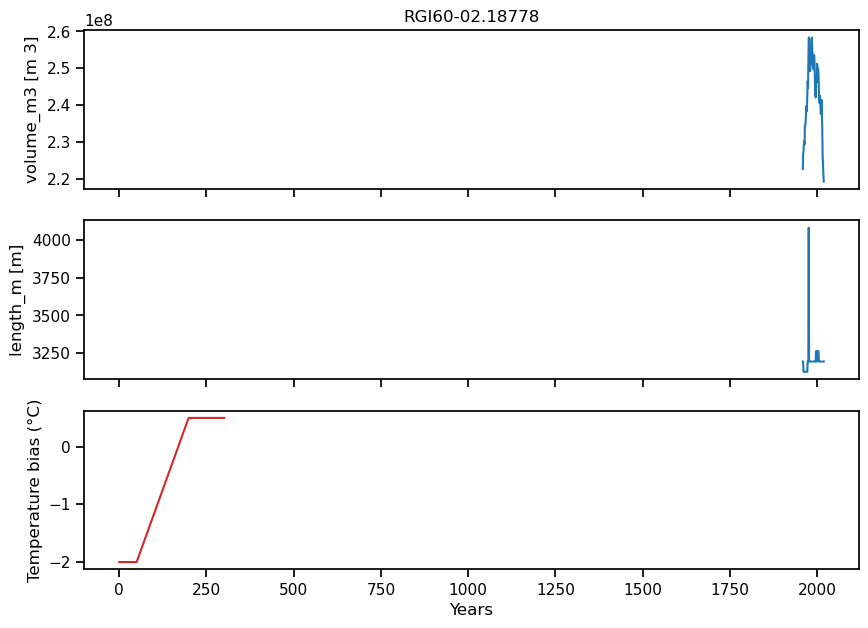

In [22]:
fig, axs = plt.subplots(nrows=3, figsize=(10, 7), sharex=True)
ds.volume_m3.plot(ax=axs[0])
ds.length_m.plot(ax=axs[1])
temp_bias_ts.plot(ax=axs[2], c='C3')
axs[0].set_xlabel(''); axs[0].set_title(f'{rgi_id}'); axs[1].set_xlabel(''); axs[2].set_xlabel('Years'); axs[2].set_ylabel('Temperature bias (°C)')